In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('../data/App Usage dataset for 10000 customers.csv')
df.head()

,Duration Used (days),Total Usage (minutes),Reason for Quitting,Cost Offered (rupees),Accepted Offer
0,141,3186,Expensive,600,True
1,154,9717,Not Useful,800,True
2,306,17820,Not Useful,500,True
3,338,28135,Expensive,500,True
4,57,5448,Expensive,800,True


### Applying feature engineering/data augmentation to expand/modify the existing data

In [4]:
df['Approx per day usage (minutes)'] = df['Total Usage (minutes)']/df['Duration Used (days)']
df['Cost paid per minute'] = df['Cost Offered (rupees)']/df['Total Usage (minutes)']
df['Accepted Offer'] = df['Accepted Offer'].map({True:1, False:0})
df.head()

,Duration Used (days),Total Usage (minutes),Reason for Quitting,Cost Offered (rupees),Accepted Offer,Approx per day usage (minutes),Cost paid per minute
0,141,3186,Expensive,600,1,22.595745,0.188324
1,154,9717,Not Useful,800,1,63.097403,0.082330
2,306,17820,Not Useful,500,1,58.235294,0.028058
3,338,28135,Expensive,500,1,83.239645,0.017771
4,57,5448,Expensive,800,1,95.578947,0.146843


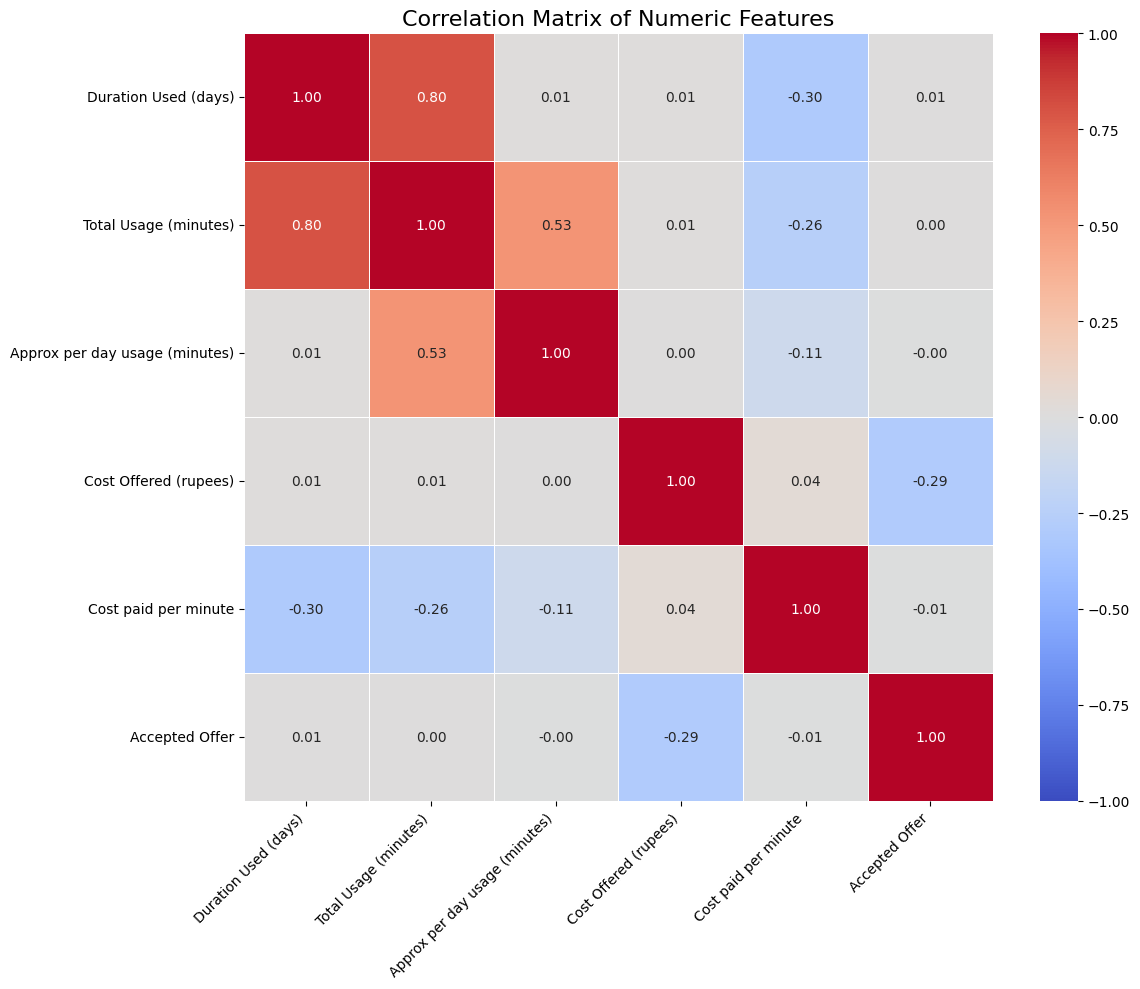

In [7]:
columns_to_include = ['Duration Used (days)', 'Total Usage (minutes)', 
                      'Approx per day usage (minutes)', 'Cost Offered (rupees)', 'Cost paid per minute', 'Accepted Offer']

numeric_df = df[columns_to_include]
corr_matrix = numeric_df.corr()
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1.0, center=0, linewidths=0.5, 
                      fmt='.2f')
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [9]:
target_correlations = corr_matrix['Accepted Offer'].sort_values(ascending=False)
print("\nCorrelations with Accepted Offer:")
print(target_correlations)


print("\nTop 10 Strongest Correlations:")
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                           corr_matrix.iloc[i, j]))


corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for pair in corr_pairs[:10]:
    print(f"{pair[0]} & {pair[1]}: {pair[2]:.3f}")


Correlations with Accepted Offer:
Accepted Offer                    1.000000
Duration Used (days)              0.006097
Total Usage (minutes)             0.004894
Approx per day usage (minutes)   -0.002063
Cost paid per minute             -0.007709
Cost Offered (rupees)            -0.294944
Name: Accepted Offer, dtype: float64

Top 10 Strongest Correlations:
Duration Used (days) & Total Usage (minutes): 0.798
Total Usage (minutes) & Approx per day usage (minutes): 0.526
Duration Used (days) & Cost paid per minute: -0.301
Cost Offered (rupees) & Accepted Offer: -0.295
Total Usage (minutes) & Cost paid per minute: -0.257
Approx per day usage (minutes) & Cost paid per minute: -0.115
Cost Offered (rupees) & Cost paid per minute: 0.045
Total Usage (minutes) & Cost Offered (rupees): 0.011
Duration Used (days) & Cost Offered (rupees): 0.010
Duration Used (days) & Approx per day usage (minutes): 0.008


#### <p>From the given correlation heatmap, we can conclude that **duration used (days)** and **total usage (minutes)** are the two fields with <br> significant correlation.</p> <p> However, since the number of fields is moderate, interpretability can be prioritized without reduction in dimensionality. </p> <p>In addition, low correlation of **cost offered** with the **accepted offer** field suggests that their is little **_linear_** relationship between the acceptance and price offered indicating that factors other than only the pricing influence the consumer's decision of accepting the offer.

In [10]:
df['Accepted Offer'].value_counts(normalize=True)*100

Accepted Offer
1    64.16
0    35.84
Name: proportion, dtype: float64

## Intuition behind building the dynamic highest pricing model based on the probability of user's acceptance:
### For recommending/suggesting highest price, given a user is likely to accept the offer with a sufficient probability, some crucial keypoints to consider when building the appropriate model are mentioned in the next markdown.

### 1. The model needs to result in outputs based on **probabilistic acceptance** of a given user rather than definitive output.
### 2. Key point to note here is that there is a _**class imbalance**_ which is depicted by the block displaying counts of 'Accepted Offer' column which is the target variable in this case. A robust model which can output probabilities and handle class imbalance is the need.
### 3. If a user, in reality, rejects the offer but the model predicts acceptance, the loss associated with a business is likely to be on the conversion side, where false positives lead to poor conversion strategy. However, if the user, in reality, accepts the offer but model predictions show rejection, there lie significant chances of revenue losses since the user will not be presented with the highest price he or she would have paid. This concludes that *false negatives* or **recall** is the crucial metric to improve upon.
### 4. Three classification models namely Logistic Regression, Random Forest Classifier, and XGBoost are tested and finally the model with the highest ROC-AUC score is finalized for further predicitons.

In [11]:
df.head()

,Duration Used (days),Total Usage (minutes),Reason for Quitting,Cost Offered (rupees),Accepted Offer,Approx per day usage (minutes),Cost paid per minute
0,141,3186,Expensive,600,1,22.595745,0.188324
1,154,9717,Not Useful,800,1,63.097403,0.082330
2,306,17820,Not Useful,500,1,58.235294,0.028058
3,338,28135,Expensive,500,1,83.239645,0.017771
4,57,5448,Expensive,800,1,95.578947,0.146843


In [12]:
#Importing the necessary libraries and packages for building a dynamic high pricing recommending model.

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

#Initializing predictor and target variables as well as categorical and numerical feature columns.

X = df.drop(columns=["Accepted Offer"])
y = df["Accepted Offer"]

cat_features = ["Reason for Quitting"]
num_features = ["Duration Used (days)", "Total Usage (minutes)", "Cost Offered (rupees)", "Approx per day usage (minutes)", "Cost paid per minute"]

#Applying preprocessing pipeline for scaling and encoding transformations crucial for efficient model training and testing.

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

#Data splitting into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#In order to handle class balancing, we can automatically compute class weights based on the training data distribution

class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))


class_distribution = np.bincount(y_train) / len(y_train)
print(f"Class distribution in training data:")
print(f"Class 0 (Rejected): {class_distribution[0]:.2%}")
print(f"Class 1 (Accepted): {class_distribution[1]:.2%}")
print(f"Computed class weights: {class_weight_dict}")

# Determining the minority class and calculating appropriate scale_pos_weight for XGBoost
if np.sum(y_train == 0) < np.sum(y_train == 1):
    # Class 0 is minority
    scale_pos_weight = np.sum(y_train == 1) / np.sum(y_train == 0)
    minority_class = 0
else:
    # Class 1 is minority
    scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
    minority_class = 1

#Building model pipelines with appropriate models which result in probabilistic outputs along with the appropriate class balancing.

models = {
    'LogisticRegression' : Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42, class_weight=class_weight_dict))
    ]),
    'RandomForest' : Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict))
    ]),
    'XGBoost' : Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(
            n_estimators=100, 
            random_state=42, 
            scale_pos_weight=scale_pos_weight if minority_class == 1 else 1/scale_pos_weight
        ))
    ]),
    'SVM' : Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(
            kernel="rbf",       
            probability=True,   
            class_weight=class_weight_dict,
            random_state=42
        ))
    ])
}

#Evaluating all the three models using cross validation with ROC-AUC parameter as the metric.

model_scores = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    model_scores[name] = cv_scores.mean()
    print(f"{name} - Mean ROC-AUC: {cv_scores.mean():.4f}")

#Selecting the best model based on the ROC-AUC score.

best_model_name = max(model_scores, key=model_scores.get)
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name} with ROC-AUC score: {model_scores[best_model_name]:.4f}")


#Defining the logic for selecting the highest price at 70% acceptance probability.

def get_highest_price(user_row, model, min_price, max_price, primary_threshold=0.7, secondary_threshold=0.5):
    price_range = np.linspace(min_price, max_price, 1000)
    user_features = user_row.copy()
    original_cost = user_features['Cost Offered (rupees)']
    user_df = pd.DataFrame([user_features.to_dict()])

    #checking whether primary threshold which is 70% is achieved, following which checking the best price.
    test_df = user_df.copy()
    test_df["Cost Offered (rupees)"] = min_price
    min_prob = model.predict_proba(test_df)[:,1][0] #calculating the probability at the minimum price.
   
    test_df["Cost Offered (rupees)"] = max_price
    max_prob = model.predict_proba(test_df)[:,1][0] #calculating the probability at maximum price.

    if min_prob >= primary_threshold:
        
        if max_prob >= primary_threshold:
            
            return max_price #returning the maximum price if user accepts with the threshold probability.

        left = 0
        right = len(price_range) - 1
        best_price = min_price
    
        while left <= right:
            mid = (left+right)//2
            test_df = user_df.copy()
            test_df["Cost Offered (rupees)"] = price_range[mid]
            prob = model.predict_proba(test_df)[:,1][0]
    
            if prob >= primary_threshold:
                best_price = price_range[mid]
                left = mid + 1
            else:
                right = mid-1
                
        return best_price

    #checking for secondary threshold which is 50%, and returning the maximum price.
    if min_prob >= secondary_threshold:

        if max_prob >= secondary_threshold:
            return max_price

        left = 0
        right = len(price_range) - 1
        best_price = min_price
    
        while left <= right:
            mid = (left+right)//2
            test_df = user_df.copy()
            test_df["Cost Offered (rupees)"] = price_range[mid]
            prob = model.predict_proba(test_df)[:,1][0]
    
            if prob >= secondary_threshold:
                best_price = price_range[mid]
                left = mid + 1
            else:
                right = mid-1
                
        return best_price
        
    return original_cost #if the probability is below even the 50% acceptance probability, return the original price.


#Training the best model selected on the training set.

best_model.fit(X_train, y_train)

#Applying k-fold validation for calculating price recommendations on the training set.

folds = 5
kf = KFold(n_splits=folds, shuffle=True, random_state=42)
train_highest_prices = pd.Series(index=X_train.index, dtype=float)
train_pred_probs = pd.Series(index=X_train.index, dtype=float)
train_threshold_used = pd.Series(index=X_train.index, dtype=str)


for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Processing fold {fold_idx+1}/{folds}...")
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train = y_train.iloc[train_idx]

    fold_min_cost = X_fold_train["Cost Offered (rupees)"].min()
    fold_max_cost = X_fold_train["Cost Offered (rupees)"].max()

    fold_model = models[best_model_name].fit(X_fold_train, y_fold_train)

    val_probs = fold_model.predict_proba(X_fold_val)[:,1]
    train_pred_probs.loc[X_fold_val.index] = val_probs

    for idx, row in X_fold_val.iterrows():
        highest_price = get_highest_price(row, fold_model, fold_min_cost, fold_max_cost) #can modify the primary threshold and secondary threshold here
        train_highest_prices[idx] = highest_price

        prob = train_pred_probs[idx]
        if prob >= 0.7:
            train_threshold_used[idx] = "primary (70%)"
        elif prob >=0.5:
            train_threshold_used[idx] = "secondary (50%)"
        else:
            train_threshold_used[idx] = "below threshold (50%)"

#Calculating the highest prices for the test set.

min_cost = X_train["Cost Offered (rupees)"].min()
max_cost = X_train["Cost Offered (rupees)"].max()
test_highest_prices = pd.Series(index=X_test.index, dtype=float)
test_pred_probs = pd.Series(best_model.predict_proba(X_test)[:,1], index=X_test.index)
test_threshold_used = pd.Series(index=X_test.index, dtype=str)



for idx, row in X_test.iterrows():
    test_highest_price = get_highest_price(row, best_model, min_cost, max_cost)
    test_highest_prices[idx] = test_highest_price

    prob = test_pred_probs[idx]
    if prob >= 0.7:
        test_threshold_used[idx] = "primary (70%)"
    elif prob >= 0.5:
        test_threshold_used[idx] = "secondary (50%)"
    else:
        test_threshold_used[idx] = "below threshold (50%)"
    

#Constructing the final dataframe with results.

df_with_prices = df.copy()
df_with_prices.loc[X_train.index, 'Highest Price Suggested'] = train_highest_prices
df_with_prices.loc[X_test.index, 'Highest Price Suggested'] = test_highest_prices
df_with_prices['Original Cost Offered'] = df_with_prices['Cost Offered (rupees)']


df_with_prices.loc[X_train.index, 'Predicted Acceptance Probability'] = train_pred_probs
df_with_prices.loc[X_test.index, 'Predicted Acceptance Probability'] = test_pred_probs

df_with_prices.loc[X_train.index, 'Threshold Used'] = train_threshold_used
df_with_prices.loc[X_test.index, 'Threshold Used'] = test_threshold_used

# Determining the model prediction using a threshold of 0.7 and 0.5
df_with_prices['Primary Threshold Met'] = (df_with_prices['Predicted Acceptance Probability'] >= 0.7).astype(int)
df_with_prices['Secondary Threshold Met'] = (df_with_prices['Predicted Acceptance Probability'] >= 0.5).astype(int)

# Including the true/original accepted offer for reference.
df_with_prices['Accepted Offer (True)'] = df_with_prices['Accepted Offer']


df_with_prices['Price Difference'] = df_with_prices['Highest Price Suggested'] - df_with_prices['Original Cost Offered']
df_with_prices['Price % Change'] = (df_with_prices['Price Difference'] / df_with_prices['Original Cost Offered'] * 100).round(2)



print("\nSample of final recommendations (10 records):")
sample_cols = [
    'Original Cost Offered', 'Highest Price Suggested', 'Price Difference', 'Price % Change',
    'Accepted Offer (True)', 'Predicted Acceptance Probability', 'Threshold Used', 
    'Primary Threshold Met', 'Secondary Threshold Met'
]
print(df_with_prices[sample_cols].sample(10))

# Evaluating the performance on the test set.
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]

# Default model performance (using sklearn's default 0.5 threshold)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_prob)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)


# Performance at primary threshold (70%)
primary_threshold = 0.7
predicted_primary = (y_test_prob >= primary_threshold).astype(int)
primary_accuracy = accuracy_score(y_test, predicted_primary)
primary_precision = precision_score(y_test, predicted_primary)
primary_recall = recall_score(y_test, predicted_primary)
primary_f1 = f1_score(y_test, predicted_primary)
primary_fp = ((predicted_primary == 1) & (y_test == 0)).sum()
primary_fn = ((predicted_primary == 0) & (y_test == 1)).sum()


# Performance at secondary threshold (50%)
secondary_threshold = 0.5
predicted_secondary = (y_test_prob >= secondary_threshold).astype(int)
secondary_accuracy = accuracy_score(y_test, predicted_secondary)
secondary_precision = precision_score(y_test, predicted_secondary)
secondary_recall = recall_score(y_test, predicted_secondary)
secondary_f1 = f1_score(y_test, predicted_secondary)
secondary_fp = ((predicted_secondary == 1) & (y_test == 0)).sum()
secondary_fn = ((predicted_secondary == 0) & (y_test == 1)).sum()



print(f"\nTest set performance of {best_model_name}:")
print(f"ROC-AUC (threshold independent): {test_auc:.4f}")

print(f"\nPrimary Threshold (70%) Metrics:")
print(f"Accuracy: {primary_accuracy:.4f}")
print(f"Precision: {primary_precision:.4f}")
print(f"Recall: {primary_recall:.4f}")
print(f"F1 Score: {primary_f1:.4f}")
print(f"False positives: {primary_fp}")
print(f"False negatives: {primary_fn}")

print(f"\nSecondary Threshold (50%) Metrics:")
print(f"Accuracy: {secondary_accuracy:.4f}")
print(f"Precision: {secondary_precision:.4f}")
print(f"Recall: {secondary_recall:.4f}")
print(f"F1 Score: {secondary_f1:.4f}")
print(f"False positives: {secondary_fp}")
print(f"False negatives: {secondary_fn}")

# Calculating the improvement in false negatives.
fn_reduction = primary_fn - secondary_fn
fn_reduction_percent = (fn_reduction / primary_fn * 100) if primary_fn > 0 else 0

print(f"\nFalse Negative Reduction:")
print(f"Absolute reduction: {fn_reduction}")
print(f"Percentage reduction: {fn_reduction_percent:.2f}%")

# Calculating the tradeoff with false positives.
fp_increase = secondary_fp - primary_fp
print(f"False Positive Increase: {fp_increase}")
print(f"This represents a tradeoff: {fn_reduction} fewer missed opportunities at the cost of {fp_increase} more false acceptances")




Class distribution in training data:
Class 0 (Rejected): 35.98%
Class 1 (Accepted): 64.03%
Computed class weights: {np.int64(0): np.float64(1.389854065323141), np.int64(1): np.float64(0.7809449433814916)}
LogisticRegression - Mean ROC-AUC: 0.6759
RandomForest - Mean ROC-AUC: 0.6292
XGBoost - Mean ROC-AUC: 0.6365
SVM - Mean ROC-AUC: 0.6683

Best model: LogisticRegression with ROC-AUC score: 0.6759
Processing fold 1/5...
Processing fold 2/5...
Processing fold 3/5...
Processing fold 4/5...
Processing fold 5/5...

Sample of final recommendations (10 records):
      Original Cost Offered  Highest Price Suggested  Price Difference  \
7454                    800               527.627628       -272.372372   
3077                    800               541.241241       -258.758759   
5227                    800               536.036036       -263.963964   
6305                    600               544.044044        -55.955956   
3902                    500               528.428428         28.4284

In [13]:
result_df = df_with_prices.copy()

In [14]:
result_df.drop(columns=["Accepted Offer", "Duration Used (days)", "Total Usage (minutes)", "Reason for Quitting", "Cost Offered (rupees)", "Approx per day usage (minutes)","Cost paid per minute"], inplace=True)


In [15]:
result_df.head()

,Highest Price Suggested,Original Cost Offered,Predicted Acceptance Probability,Threshold Used,Primary Threshold Met,Secondary Threshold Met,Accepted Offer (True),Price Difference,Price % Change
0,533.633634,600,0.630970,secondary (50%),0,1,1,-66.366366,-11.06
1,538.038038,800,0.412918,below threshold (50%),0,0,1,-261.961962,-32.75
2,539.639640,500,0.736917,primary (70%),1,1,1,39.639640,7.93
3,541.241241,500,0.739443,primary (70%),1,1,1,41.241241,8.25
4,524.424424,800,0.388166,below threshold (50%),0,0,1,-275.575576,-34.45


In [28]:
#Customers who in reality, accepted the offer irrespective of the model's prediction (priority).
true_accepted = result_df[result_df["Accepted Offer (True)"]==1]

In [29]:
true_accepted

,Highest Price Suggested,Original Cost Offered,Predicted Acceptance Probability,Threshold Used,Primary Threshold Met,Secondary Threshold Met,Accepted Offer (True),Price Difference,Price % Change
0,533.633634,600,0.630970,secondary (50%),0,1,1,-66.366366,-11.06
1,538.038038,800,0.412918,below threshold (50%),0,0,1,-261.961962,-32.75
2,539.639640,500,0.736917,primary (70%),1,1,1,39.639640,7.93
3,541.241241,500,0.739443,primary (70%),1,1,1,41.241241,8.25
4,524.424424,800,0.388166,below threshold (50%),0,0,1,-275.575576,-34.45
...,...,...,...,...,...,...,...,...,...
9986,512.012012,800,0.384350,below threshold (50%),0,0,1,-287.987988,-36.00
9991,541.641642,800,0.409125,below threshold (50%),0,0,1,-258.358358,-32.29
9995,521.621622,600,0.617614,secondary (50%),0,1,1,-78.378378,-13.06
9996,534.834835,500,0.733575,primary (70%),1,1,1,34.834835,6.97


In [18]:
true_accepted["Threshold Used"].value_counts()

Threshold Used
secondary (50%)          2576
below threshold (50%)    2282
primary (70%)            1558
Name: count, dtype: int64

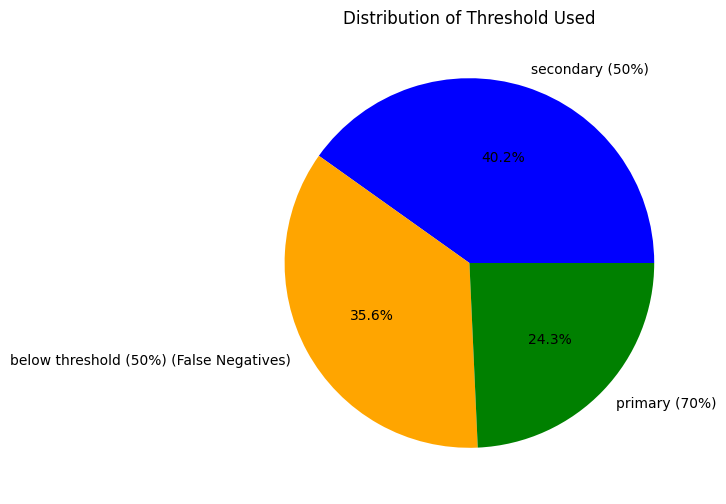

In [19]:
threshold_counts = true_accepted["Threshold Used"].value_counts(normalize=True).round(4) * 100

colors = ["blue", "orange", "green"]
labels = threshold_counts.index.tolist()

if "below threshold (50%)" in labels:
    labels[labels.index("below threshold (50%)")] += " (False Negatives)"

plt.figure(figsize=(6, 6))
plt.pie(threshold_counts, labels=labels, autopct="%1.1f%%", colors=colors)
plt.title("Distribution of Threshold Used")
plt.show()

### Visualizing the total count and % of the users who are liable to be recommended higher prices as well as the average price increase from the original cost offered.

In [22]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
total_users = result_df.shape[0]


price_increase_users = true_accepted[
    true_accepted["Highest Price Suggested"] > true_accepted["Original Cost Offered"]
]


primary_count = price_increase_users[price_increase_users["Primary Threshold Met"] == 1].shape[0]
secondary_count = price_increase_users[
    (price_increase_users["Primary Threshold Met"] == 0) & 
    (price_increase_users["Secondary Threshold Met"] == 1)
].shape[0]

# Percentage of total users
primary_percentage = (primary_count / total_users) * 100
secondary_percentage = (secondary_count / total_users) * 100

# Average price increase
primary_avg_increase = price_increase_users[
    price_increase_users["Primary Threshold Met"] == 1
]["Highest Price Suggested"].sub(price_increase_users["Original Cost Offered"]).mean()

secondary_avg_increase = price_increase_users[
    (price_increase_users["Primary Threshold Met"] == 0) & 
    (price_increase_users["Secondary Threshold Met"] == 1)
]["Highest Price Suggested"].sub(price_increase_users["Original Cost Offered"]).mean()

# Percentage increase relative to original price
primary_avg_percentage_increase = (primary_avg_increase / 
                                   price_increase_users[price_increase_users["Primary Threshold Met"] == 1]["Original Cost Offered"].mean()) * 100

secondary_avg_percentage_increase = (secondary_avg_increase / 
                                     price_increase_users[(price_increase_users["Primary Threshold Met"] == 0) & 
                                                          (price_increase_users["Secondary Threshold Met"] == 1)]["Original Cost Offered"].mean()) * 100


categories = ["Primary (>=70%)", "Secondary (>=50%)"]


fig = make_subplots(rows=2, cols=2, subplot_titles=[
    "Absolute Counts of Users", 
    "Percentage of Total Users", 
    "Average Price Increase", 
    "Percentage of Avg Price Increase"
])

# Subplot 1: Absolute Counts
fig.add_trace(go.Bar(x=categories, y=[primary_count, secondary_count], 
                     marker_color="blue", name="Number of customers to present with higher pricing"), row=1, col=1)

# Subplot 2: Percentage of Total Users
fig.add_trace(go.Bar(x=categories, y=[primary_percentage, secondary_percentage], 
                     marker_color="orange", name="Percentage of total customers"), row=1, col=2)

# Subplot 3: Average Price Increase
fig.add_trace(go.Bar(x=categories, y=[primary_avg_increase, secondary_avg_increase], 
                     marker_color="green", name="Avg price increase from the original"), row=2, col=1)

# Subplot 4: Percentage Increase Relative to Original Price
fig.add_trace(go.Bar(x=categories, y=[primary_avg_percentage_increase, secondary_avg_percentage_increase], 
                     marker_color="red", name="Percentage of Avg price increase"), row=2, col=2)

# Update layout
fig.update_layout(title_text="User Acceptance & Price Adjustments", 
                  height=800, width=900, showlegend=True)

# Show figure
fig.show()


## KEY FINDINGS -->
### The visualizations demonstrate that users for whom the model suggests higher price with 70% or more probabilistic acceptance should be the priority instead of 50% or secondary threshold group as the numbers of secondary group are minimal. Over 1557 customers are expected to pay a higher price than what is originally offered, indicating revenue optimization opportunity.

### Even though the total count of users whose acceptance probability is between 50% and 70% is minimal, the price increase suggested by the model is significantly higher than the primary threshold category. Hence, the price increase for primary group can be improved further but below than what is recommended for the secondary group.

### Till now, we have only talked about the two categories but we need to address the 35.57% of the false negatives i.e. users who have originally accepted the offer but model is less than 50% confident for acceptance. In this case, an optimal recommendation could be to not change the original prices offered since there exist no records where the model recommends a higer price for the false negatives.


In [23]:
true_accepted[
    (true_accepted["Highest Price Suggested"]>true_accepted["Original Cost Offered"]) & 
    (true_accepted["Threshold Used"] == "below threshold (50%)")
]
#Here we can clearly see that no records with recommend price higher than original exist for below threshold consumers.

,Highest Price Suggested,Original Cost Offered,Predicted Acceptance Probability,Threshold Used,Primary Threshold Met,Secondary Threshold Met,Accepted Offer (True),Price Difference,Price % Change


### Additionally, for the secondary threshold group, where there exist too less users for which the price recommended is higher than the original, a similar strategy as for false negatives can be adopted since there exist a significant amount of users for whom the recommend price generated by the model does not overtake the original cost offered.

In [24]:
secondary_with_high_original = true_accepted[
    (true_accepted["Highest Price Suggested"]<=true_accepted["Original Cost Offered"]) & 
    (true_accepted["Threshold Used"] == "secondary (50%)")
].shape[0]

print("Number of customers who pay higher than the model recommended price at a threshold between 50% and 70%:", secondary_with_high_original)

true_accepted[
    (true_accepted["Highest Price Suggested"]<=true_accepted["Original Cost Offered"]) & 
    (true_accepted["Threshold Used"] == "secondary (50%)")
]

#As evident, out of the 2576 secondary threshold users (visualized in pie chart and show above it), 2535 users...
#...have original cost offered higher or equal to the price recommended by the model
#Hence, no change in costs seem a better option until model improves.


Number of customers who pay higher than the model recommended price at a threshold between 50% and 70%: 2535


,Highest Price Suggested,Original Cost Offered,Predicted Acceptance Probability,Threshold Used,Primary Threshold Met,Secondary Threshold Met,Accepted Offer (True),Price Difference,Price % Change
0,533.633634,600,0.630970,secondary (50%),0,1,1,-66.366366,-11.06
7,532.432432,600,0.629565,secondary (50%),0,1,1,-67.567568,-11.26
12,528.428428,600,0.625056,secondary (50%),0,1,1,-71.571572,-11.93
15,540.840841,600,0.639393,secondary (50%),0,1,1,-59.159159,-9.86
18,543.243243,700,0.529448,secondary (50%),0,1,1,-156.756757,-22.39
...,...,...,...,...,...,...,...,...,...
9964,542.442442,600,0.640287,secondary (50%),0,1,1,-57.557558,-9.59
9972,526.026026,600,0.622605,secondary (50%),0,1,1,-73.973974,-12.33
9975,542.442442,600,0.640588,secondary (50%),0,1,1,-57.557558,-9.59
9976,526.026026,600,0.622312,secondary (50%),0,1,1,-73.973974,-12.33
